In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def show(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# DEFINE PARAMETERS

In [3]:
# params
block=8
coeff=64
filename='C:/Users/Devanshu/Desktop/My folder/CS517/P3_2021CSB1082_Devanshu/test-images/book-cover.tif'

# JPEG ENCODING

Q_MAT

In [4]:
Q_mat=np.array([[16,11,10,16,24,40,51,61],
[12,12,14,19,26,58,60,55],
[14,13,16,24,40,57,69,56],
[14,17,22,29,51,87,80,62],
[18,22,37,56,68,109,103,77],
[24,35,55,64,81,104,113,92],
[49,64,78,87,103,121,120,101],
[72,92,95,98,112,100,103,99]])

In [5]:
def dct(img):
    a,b=img.shape[:2]
    if(a//block * block!=a):
        a=math.ceil(a/block)*block
    if(b//block*block!=b):
        b=math.ceil(b/block)*block
    img2=np.zeros((a,b))
    img2[:img.shape[0],:img.shape[1]]=img
    img_res=np.zeros_like(img2)
    for i in range(0,a,block):
        for j in range(0,b,block):
            part=img2[i:i+block, j:j+block]
            part_dct=cv2.dct(part)
            img_res[i:i+block, j:j+block]=part_dct
    return img_res

In [6]:
def quant(img):
    res=np.zeros_like(img)
    a,b=img.shape[:2]
    for i in range(0,a,block):
        for j in range(0,b,block):
            res[i:i+block, j:j+block]=np.round(np.divide(img[i:i+block, j:j+block], Q_mat))
    return res

In [7]:
def zigzag(matrix):
    arr=np.concatenate([np.diagonal(matrix[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-matrix.shape[0], matrix.shape[0])])
    arr=np.trim_zeros(arr, 'b')
    return arr[:min(coeff, len(arr))]

In [8]:
def zigzag_list(quantised):
    res=[]
    a,b=quantised.shape[:2]
    for i in range(0, a, block):
        for j in range(0,b,block):
            res.append(zigzag(quantised[i:i+block, j:j+block]))
    return res

In [9]:
test_img=np.array([[-76,-73,-67,-62,-58,-67,-64,-55],
[-65,-69,-62,-38,-19,-43,-59,-56],
[-66,-69,-60,-15,16,-24,-62,-55],[-65,-70,-57,-6,26,-22,-58,-59],
[-61,-67,-60,-24,-2,-40,-60,-58],
[-49,-63,-68,-58,-51,-65,-70,-53],
[-43,-57,-64,-69,-73,-67,-63,-45],
[-41,-49,-59,-60,-63,-52,-50,-34]], dtype=np.float32)

In [10]:
def compressed_size(arr):
    bits=0
    for ax in arr:
        for row in ax:
            for i in row:
                bits+=(math.floor(math.log2(i))+1 if i>1 else 1)
    return bits/(8*1024)

In [11]:
img=cv2.imread(filename)
h,w,ch=img.shape

img_ycbcr=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
y,cb,cr=cv2.split(img_ycbcr)


In [12]:
y_dct,cb_dct,cr_dct=dct(y),dct(cb),dct(cr)
y_quant,cb_quant,cr_quant=quant(y_dct),quant(cb_dct),quant(cr_dct)
# y_quant.shape

In [13]:
y_zigged, cb_zigged, cr_zigged=zigzag_list(y_quant), zigzag_list(cb_quant),zigzag_list(cr_quant)
merged=[y_zigged, cb_zigged, cr_zigged]

In [14]:
original_size=math.ceil(h*w*ch/1024)
comp_size=math.ceil(compressed_size(merged))
print("original size:",original_size,"kb")
print("compressed size:",comp_size,"kb")
print("ratio:", original_size/comp_size)

original size: 1387 kb
compressed size: 26 kb
ratio: 53.34615384615385


# JPEG DECODING

In [15]:
def unzigzag_traversal(arr):
    n = int(np.sqrt(len(arr)))
    block = np.zeros((n, n))
    index = 0

    for i in range(n + n - 1):
        if i % 2 == 0:
            for j in range(max(0, i - n + 1), min(n, i + 1)):
                block[i-j, j] = arr[index]
                index += 1
        else:
            for j in range(max(0, i - n + 1), min(n, i + 1)):
                block[j, i-j] = arr[index]
                index += 1
    return block


In [16]:

def un_zag(merged):
    a,b=img.shape[:2]
    if(a//block * block!=a):
        a=math.ceil(a/block)*block
    if(b//block*block!=b):
        b=math.ceil(b/block)*block
    print(a,b)
    final_img=[]
    for layer in merged:
        res=[]
        for x in layer:
            x=np.pad(x, (0, block*block-len(x)), mode='constant')
            x=unzigzag_traversal(x)
            res.append(x)
        final_img.append(np.block([[res[i * b//8 + j] for j in range(b//8)] for i in range(a//8)]))
    return final_img

In [17]:
def unquant(img):
    res=np.zeros_like(img)
    a,b=img.shape[:2]
    for i in range(0,a,block):
        for j in range(0,b,block):
            res[i:i+block, j:j+block]=(img[i:i+block, j:j+block]*Q_mat)
    return res


In [18]:

def idct(img):
    a,b=img.shape[:2]
    img=np.float32(img)
    res=np.zeros_like(img)
    for i in range(0,a,block):
        for j in range(0,b,block):
            res[i:i+block, j:j+block]=cv2.idct(img[i:i+block, j:j+block].astype(np.float32))
    return res

In [19]:
unquantized=un_zag(merged)

688 688


In [20]:
y_dct,cb_dct,cr_dct=unquant(unquantized[0]),unquant(unquantized[1]),unquant(unquantized[2])
y,cb,cr=idct(y_dct),idct(cb_dct),idct(cr_dct)

In [21]:
# y=np.uint8(y)
# cb=np.uint8(cb)
# cr=np.uint8(cr)

In [22]:
final_img=cv2.merge((y,cb,cr))
# final_img=cv2.

In [23]:
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
final_img=cv2.cvtColor(cv2.convertScaleAbs(final_img), cv2.COLOR_YCR_CB2RGB)
final_img=final_img[:img.shape[0], :img.shape[1], :]

## RESULTS

(-0.5, 687.5, 687.5, -0.5)

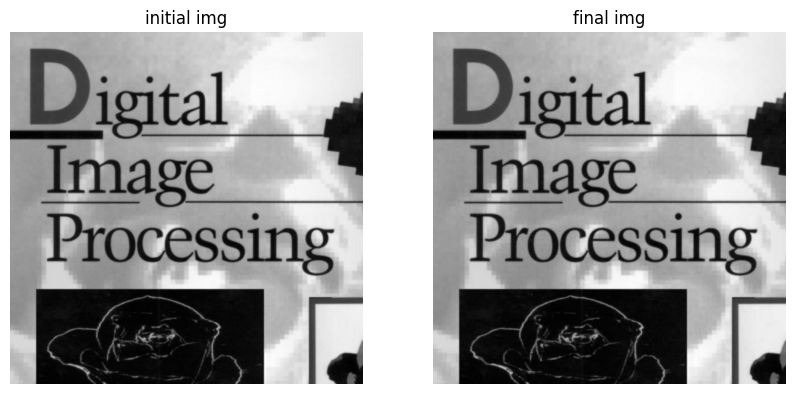

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title('initial img')
axs[0].axis('off')
axs[1].imshow(final_img)
axs[1].set_title('final img')
axs[1].axis('off')

# ERROR

In [25]:
err_rmse=np.sqrt(np.mean(np.square(img-final_img)))
err_psnr=20*np.log10(255/err_rmse)
print("rmse:", err_rmse)
print("psnr:", err_psnr)
print("compression ratio:", original_size/comp_size)


rmse: 2.0955925364180854
psnr: 41.70466674843687
compression ratio: 53.34615384615385
